In [1]:
# =============================================================================
# CONFIGURAZIONE PARAMETRI PORTAFOGLIO DINAMICO
# =============================================================================

# Parametri di ranking delle strategie
N_TOP_STRATEGIES = 3      # Numero di strategie migliori da favorire
N_WORST_STRATEGIES = 3    # Numero di strategie peggiori da penalizzare

# Altri parametri configurabili
DEFAULT_REBALANCE_THRESHOLD = 0.05  # Threshold di ribilanciamento di default (5%)
REBALANCE_FREQUENCY = 'W'           # Frequenza di ribilanciamento ('W' = settimanale)
INITIAL_PORTFOLIO_VALUE = 10000.0   # Valore iniziale del portafoglio

print(f"📊 CONFIGURAZIONE PORTAFOGLIO DINAMICO")
print(f"Top strategies da favorire: {N_TOP_STRATEGIES}")
print(f"Worst strategies da penalizzare: {N_WORST_STRATEGIES}")
print(f"Threshold di ribilanciamento default: {DEFAULT_REBALANCE_THRESHOLD:.1%}")
print(f"Frequenza ribilanciamento: {REBALANCE_FREQUENCY}")
print(f"Valore iniziale portafoglio: ${INITIAL_PORTFOLIO_VALUE:,.0f}")

📊 CONFIGURAZIONE PORTAFOGLIO DINAMICO
Top strategies da favorire: 3
Worst strategies da penalizzare: 3
Threshold di ribilanciamento default: 5.0%
Frequenza ribilanciamento: W
Valore iniziale portafoglio: $10,000


In [2]:
import pandas as pd
import glob
import os

# Percorso ai file CSV delle strategie
csv_files = glob.glob("./DATA/eurchf/*.csv")

# Funzione per leggere e pulire ogni file
frames = []
for file in csv_files:
    # Estraggo il nome strategia dal nome file
    strategy = os.path.basename(file).replace('.csv', '')
    # Leggo il file gestendo possibili codifiche e separatori
    try:
        df = pd.read_csv(file, sep='\t', encoding='utf-16', engine='python')
    except Exception:
        df = pd.read_csv(file, sep='\t', encoding='utf-8', engine='python')
    # Rimuovo eventuali colonne con nomi strani
    df.columns = [c.strip('<> \r\n\t').upper() for c in df.columns]
    # Prendo solo DATE e BALANCE
    df = df[[col for col in df.columns if 'DATE' in col or 'BALANCE' in col]]
    # Rinomino le colonne
    df = df.rename(columns={df.columns[0]: 'DATE', df.columns[1]: f'BALANCE_{strategy}'})
    # Pulizia e conversione timestamp
    df['DATE'] = df['DATE'].astype(str).str.strip()
    frames.append(df)

# Merge progressivo su DATE
from functools import reduce
merged = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), frames)

# Ordina per data
merged = merged.sort_values('DATE').reset_index(drop=True)

# Mostra le prime righe
merged.head()

,DATE,"BALANCE_eurchf_1m_120,2","BALANCE_eurchf_1m_7200,0.5","BALANCE_eurchf_1m_1440,1","BALANCE_eurchf_5m_120,2","BALANCE_eurchf_5m_1440,0.5","BALANCE_eurchf_15m_1440,0.1"
0,2023.01.01 00:00,10000.00,10000.0,10000.0,10000.0,10000.0,10000.0
1,2023.01.02 01:04,NaN,9983.7,NaN,NaN,9983.7,NaN
2,2023.01.02 01:05,NaN,9983.7,NaN,NaN,9983.7,NaN
3,2023.01.02 01:18,9999.24,NaN,NaN,NaN,NaN,NaN
4,2023.01.02 02:31,9999.24,NaN,NaN,NaN,NaN,NaN


In [3]:
# Applica forward fill per gestire i mismatch temporali
merged_ffill = merged.ffill()
merged_ffill.head()

,DATE,"BALANCE_eurchf_1m_120,2","BALANCE_eurchf_1m_7200,0.5","BALANCE_eurchf_1m_1440,1","BALANCE_eurchf_5m_120,2","BALANCE_eurchf_5m_1440,0.5","BALANCE_eurchf_15m_1440,0.1"
0,2023.01.01 00:00,10000.00,10000.0,10000.0,10000.0,10000.0,10000.0
1,2023.01.02 01:04,10000.00,9983.7,10000.0,10000.0,9983.7,10000.0
2,2023.01.02 01:05,10000.00,9983.7,10000.0,10000.0,9983.7,10000.0
3,2023.01.02 01:18,9999.24,9983.7,10000.0,10000.0,9983.7,10000.0
4,2023.01.02 02:31,9999.24,9983.7,10000.0,10000.0,9983.7,10000.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Conversione timestamp in datetime
merged_ffill['DATE'] = pd.to_datetime(merged_ffill['DATE'], format='%Y.%m.%d %H:%M')

# Ordina per data
merged_ffill = merged_ffill.sort_values('DATE').reset_index(drop=True)

# Estrarre solo le colonne BALANCE
balance_cols = [col for col in merged_ffill.columns if 'BALANCE' in col]
print(f"Strategie trovate: {len(balance_cols)}")
print(f"Colonne balance: {balance_cols}")

# Visualizza il range temporale
print(f"Periodo: {merged_ffill['DATE'].min()} - {merged_ffill['DATE'].max()}")
print(f"Numero di osservazioni: {len(merged_ffill)}")

merged_ffill.head()

Strategie trovate: 6
Colonne balance: ['BALANCE_eurchf_1m_120,2', 'BALANCE_eurchf_1m_7200,0.5', 'BALANCE_eurchf_1m_1440,1', 'BALANCE_eurchf_5m_120,2', 'BALANCE_eurchf_5m_1440,0.5', 'BALANCE_eurchf_15m_1440,0.1']
Periodo: 2023-01-01 00:00:00 - 2025-07-04 23:58:00
Numero di osservazioni: 33324


,DATE,"BALANCE_eurchf_1m_120,2","BALANCE_eurchf_1m_7200,0.5","BALANCE_eurchf_1m_1440,1","BALANCE_eurchf_5m_120,2","BALANCE_eurchf_5m_1440,0.5","BALANCE_eurchf_15m_1440,0.1"
0,2023-01-01 00:00:00,10000.00,10000.0,10000.0,10000.0,10000.0,10000.0
1,2023-01-02 01:04:00,10000.00,9983.7,10000.0,10000.0,9983.7,10000.0
2,2023-01-02 01:05:00,10000.00,9983.7,10000.0,10000.0,9983.7,10000.0
3,2023-01-02 01:18:00,9999.24,9983.7,10000.0,10000.0,9983.7,10000.0
4,2023-01-02 02:31:00,9999.24,9983.7,10000.0,10000.0,9983.7,10000.0


In [5]:
def dynamic_rebalance_portfolio(df, balance_cols, rebalance_threshold=DEFAULT_REBALANCE_THRESHOLD, 
                               rebalance_freq=REBALANCE_FREQUENCY, n_top=N_TOP_STRATEGIES, 
                               n_worst=N_WORST_STRATEGIES):
    """
    Implementa un portafoglio con ribilanciamento dinamico basato sulla performance settimanale.
    
    Parameters:
    - df: DataFrame con DATE e colonne BALANCE
    - balance_cols: lista delle colonne balance
    - rebalance_threshold: percentuale da redistribuire (0.05 = 5%)
    - rebalance_freq: frequenza di ribilanciamento ('W' = settimanale)
    - n_top: numero di strategie migliori da favorire
    - n_worst: numero di strategie peggiori da penalizzare
    """
    
    # Copia del DataFrame
    data = df.copy()
    n_strategies = len(balance_cols)
    
    # Inizializza pesi uguali per tutte le strategie
    initial_weight = 1.0 / n_strategies
    weights = pd.DataFrame(index=data.index, columns=balance_cols)
    weights.iloc[0] = initial_weight
    
    # Calcola i rendimenti normalizzati (da valore iniziale)
    returns_df = data[balance_cols].pct_change().fillna(0)
    
    # Traccia la performance settimanale
    weekly_performance = []
    rebalance_dates = []
    
    # Variabili per il portafoglio
    portfolio_value = [INITIAL_PORTFOLIO_VALUE]  # Valore iniziale del portafoglio
    current_weights = np.array([initial_weight] * n_strategies)
    
    # Resample per settimane (usando l'ultimo valore di ogni settimana)
    weekly_data = data.set_index('DATE').resample('W').last()
    
    for i in range(1, len(data)):
        current_date = data.iloc[i]['DATE']
        
        # Mantieni i pesi precedenti
        weights.iloc[i] = current_weights
        
        # Calcola il nuovo valore del portafoglio
        strategy_returns = returns_df.iloc[i].values
        portfolio_return = np.sum(current_weights * strategy_returns)
        new_portfolio_value = portfolio_value[-1] * (1 + portfolio_return)
        portfolio_value.append(new_portfolio_value)
        
        # Verifica se è time di ribilanciamento (ogni lunedì)
        if current_date.weekday() == 0 and i > 7:  # Lunedì e dopo almeno una settimana
            # Calcola performance della settimana precedente
            week_ago_idx = max(0, i - 7)
            week_performance = {}
            
            for col in balance_cols:
                start_val = data.iloc[week_ago_idx][col]
                end_val = data.iloc[i-1][col]  # Usa i-1 per evitare lookahead bias
                
                if start_val != 0:
                    perf = (end_val - start_val) / start_val
                    week_performance[col] = perf
                else:
                    week_performance[col] = 0
            
            # Ordina per performance
            sorted_strategies = sorted(week_performance.items(), key=lambda x: x[1], reverse=True)
            
            # Prendi le top N e le worst N strategie (o meno se ci sono meno strategie)
            n_top_actual = min(n_top, len(sorted_strategies))
            n_worst_actual = min(n_worst, len(sorted_strategies))
            
            top_strategies = [s[0] for s in sorted_strategies[:n_top_actual]]
            worst_strategies = [s[0] for s in sorted_strategies[-n_worst_actual:]]
            
            # Calcola i nuovi pesi
            new_weights = current_weights.copy()
            
            # Rimuovi peso dalle strategie peggiori
            total_removed = 0
            for col in worst_strategies:
                if col in balance_cols:
                    idx = balance_cols.index(col)
                    reduction = min(rebalance_threshold / n_worst_actual, new_weights[idx] * 0.5)  # Max 50% reduction
                    new_weights[idx] -= reduction
                    total_removed += reduction
            
            # Aggiungi peso alle strategie migliori
            for col in top_strategies:
                if col in balance_cols:
                    idx = balance_cols.index(col)
                    new_weights[idx] += total_removed / n_top_actual
            
            # Normalizza i pesi per assicurarsi che sommino a 1
            new_weights = new_weights / np.sum(new_weights)
            current_weights = new_weights
            
            # Salva per analisi
            weekly_performance.append({
                'date': current_date,
                'top_strategies': top_strategies,
                'worst_strategies': worst_strategies,
                'performance': week_performance,
                'n_top_used': n_top_actual,
                'n_worst_used': n_worst_actual
            })
            rebalance_dates.append(current_date)
    
    # Crea DataFrame dei risultati
    weights_df = pd.DataFrame(weights.values, columns=balance_cols, index=data['DATE'])
    portfolio_df = pd.DataFrame({
        'DATE': data['DATE'],
        'PORTFOLIO_VALUE': portfolio_value
    })
    
    return portfolio_df, weights_df, weekly_performance, rebalance_dates

# Test con parametri configurabili
portfolio_result, weights_result, weekly_perf, rebal_dates = dynamic_rebalance_portfolio(
    merged_ffill, balance_cols, rebalance_threshold=DEFAULT_REBALANCE_THRESHOLD
)

print(f"🎯 Portafoglio creato con configurazione:")
print(f"   - Top {N_TOP_STRATEGIES} strategie favorite")
print(f"   - Worst {N_WORST_STRATEGIES} strategie penalizzate")
print(f"   - Threshold: {DEFAULT_REBALANCE_THRESHOLD:.1%}")
print(f"📊 Risultati:")
print(f"   - Valore finale: ${portfolio_result['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")
print(f"   - Numero di ribilanciamenti: {len(rebal_dates)}")
portfolio_result.tail()

🎯 Portafoglio creato con configurazione:
   - Top 3 strategie favorite
   - Worst 3 strategie penalizzate
   - Threshold: 5.0%
📊 Risultati:
   - Valore finale: $9,374.41
   - Numero di ribilanciamenti: 6332


,DATE,PORTFOLIO_VALUE
33319,2025-07-04 21:42:00,9382.551033
33320,2025-07-04 21:42:00,9382.551033
33321,2025-07-04 23:09:00,9374.411649
33322,2025-07-04 23:54:00,9374.411649
33323,2025-07-04 23:58:00,9374.411649


In [6]:
def grid_search_rebalance_threshold(df, balance_cols, threshold_range=np.arange(0.01, 0.20, 0.01),
                                   n_top=N_TOP_STRATEGIES, n_worst=N_WORST_STRATEGIES):
    """
    Esegue grid search per trovare il threshold ottimale di ribilanciamento.
    
    Parameters:
    - df: DataFrame con DATE e colonne BALANCE
    - balance_cols: lista delle colonne balance
    - threshold_range: range di threshold da testare
    - n_top: numero di strategie migliori da favorire
    - n_worst: numero di strategie peggiori da penalizzare
    """
    results = []
    
    print(f"🔍 GRID SEARCH CONFIGURATION:")
    print(f"   - Testing {len(threshold_range)} threshold values...")
    print(f"   - Top {n_top} strategies will be favored")
    print(f"   - Worst {n_worst} strategies will be penalized")
    print(f"   - Threshold range: {threshold_range.min():.2%} to {threshold_range.max():.2%}")
    print()
    
    for i, threshold in enumerate(threshold_range):
        print(f"Progresso: {i+1}/{len(threshold_range)} - Threshold: {threshold:.3f}", end='\r')
        
        try:
            portfolio_df, weights_df, weekly_perf, rebal_dates = dynamic_rebalance_portfolio(
                df, balance_cols, rebalance_threshold=threshold, n_top=n_top, n_worst=n_worst
            )
            
            # Calcola metriche di performance
            final_value = portfolio_df['PORTFOLIO_VALUE'].iloc[-1]
            initial_value = portfolio_df['PORTFOLIO_VALUE'].iloc[0]
            total_return = (final_value - initial_value) / initial_value
            
            # Calcola Sharpe ratio (approssimativo)
            returns = portfolio_df['PORTFOLIO_VALUE'].pct_change().dropna()
            sharpe = returns.mean() / returns.std() * np.sqrt(252*24*60) if returns.std() > 0 else 0
            
            # Calcola max drawdown
            portfolio_df['PEAK'] = portfolio_df['PORTFOLIO_VALUE'].cummax()
            portfolio_df['DRAWDOWN'] = (portfolio_df['PORTFOLIO_VALUE'] - portfolio_df['PEAK']) / portfolio_df['PEAK']
            max_drawdown = portfolio_df['DRAWDOWN'].min()
            
            # Numero di ribilanciamenti
            num_rebalances = len(rebal_dates)
            
            results.append({
                'threshold': threshold,
                'final_value': final_value,
                'total_return': total_return,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'num_rebalances': num_rebalances,
                'n_top_used': n_top,
                'n_worst_used': n_worst
            })
            
        except Exception as e:
            print(f"Errore con threshold {threshold}: {e}")
            continue
    
    print(f"\n✅ Grid search completato! Testati {len(results)} parametri.")
    return pd.DataFrame(results)

# Esegui grid search con parametri configurabili
print("🚀 Inizio ottimizzazione threshold...")
optimization_results = grid_search_rebalance_threshold(
    merged_ffill, balance_cols, 
    threshold_range=np.arange(0.01, 0.15, 0.01),
    n_top=N_TOP_STRATEGIES,
    n_worst=N_WORST_STRATEGIES
)

# Trova il miglior threshold
best_result = optimization_results.loc[optimization_results['total_return'].idxmax()]
print(f"\n🎯 RISULTATI OTTIMIZZAZIONE:")
print(f"   Miglior threshold: {best_result['threshold']:.3f}")
print(f"   Ritorno totale: {best_result['total_return']:.2%}")
print(f"   Sharpe ratio: {best_result['sharpe_ratio']:.3f}")
print(f"   Max drawdown: {best_result['max_drawdown']:.2%}")
print(f"   Configurazione: Top {best_result['n_top_used']} + Worst {best_result['n_worst_used']}")

optimization_results.head(10)

🚀 Inizio ottimizzazione threshold...
🔍 GRID SEARCH CONFIGURATION:
   - Testing 14 threshold values...
   - Top 3 strategies will be favored
   - Worst 3 strategies will be penalized
   - Threshold range: 1.00% to 14.00%

Progresso: 14/14 - Threshold: 0.140
✅ Grid search completato! Testati 14 parametri.

🎯 RISULTATI OTTIMIZZAZIONE:
   Miglior threshold: 0.040
   Ritorno totale: -6.21%
   Sharpe ratio: -2.608
   Max drawdown: -18.52%
   Configurazione: Top 3.0 + Worst 3.0


,threshold,final_value,total_return,sharpe_ratio,max_drawdown,num_rebalances,n_top_used,n_worst_used
0,0.01,9276.289629,-0.072371,-3.030163,-0.194907,6332,3,3
1,0.02,9344.181381,-0.065582,-2.714619,-0.188703,6332,3,3
2,0.03,9374.191218,-0.062581,-2.604495,-0.185881,6332,3,3
3,0.04,9378.960716,-0.062104,-2.608223,-0.185226,6332,3,3
4,0.05,9374.411649,-0.062559,-2.659015,-0.185254,6332,3,3
5,0.06,9366.224350,-0.063378,-2.727625,-0.185425,6332,3,3
6,0.07,9357.372209,-0.064263,-2.799030,-0.185616,6332,3,3
7,0.08,9347.991875,-0.065201,-2.872132,-0.185815,6332,3,3
8,0.09,9338.060551,-0.066194,-2.946735,-0.186018,6332,3,3
9,0.10,9327.218508,-0.067278,-3.024391,-0.186227,6332,3,3


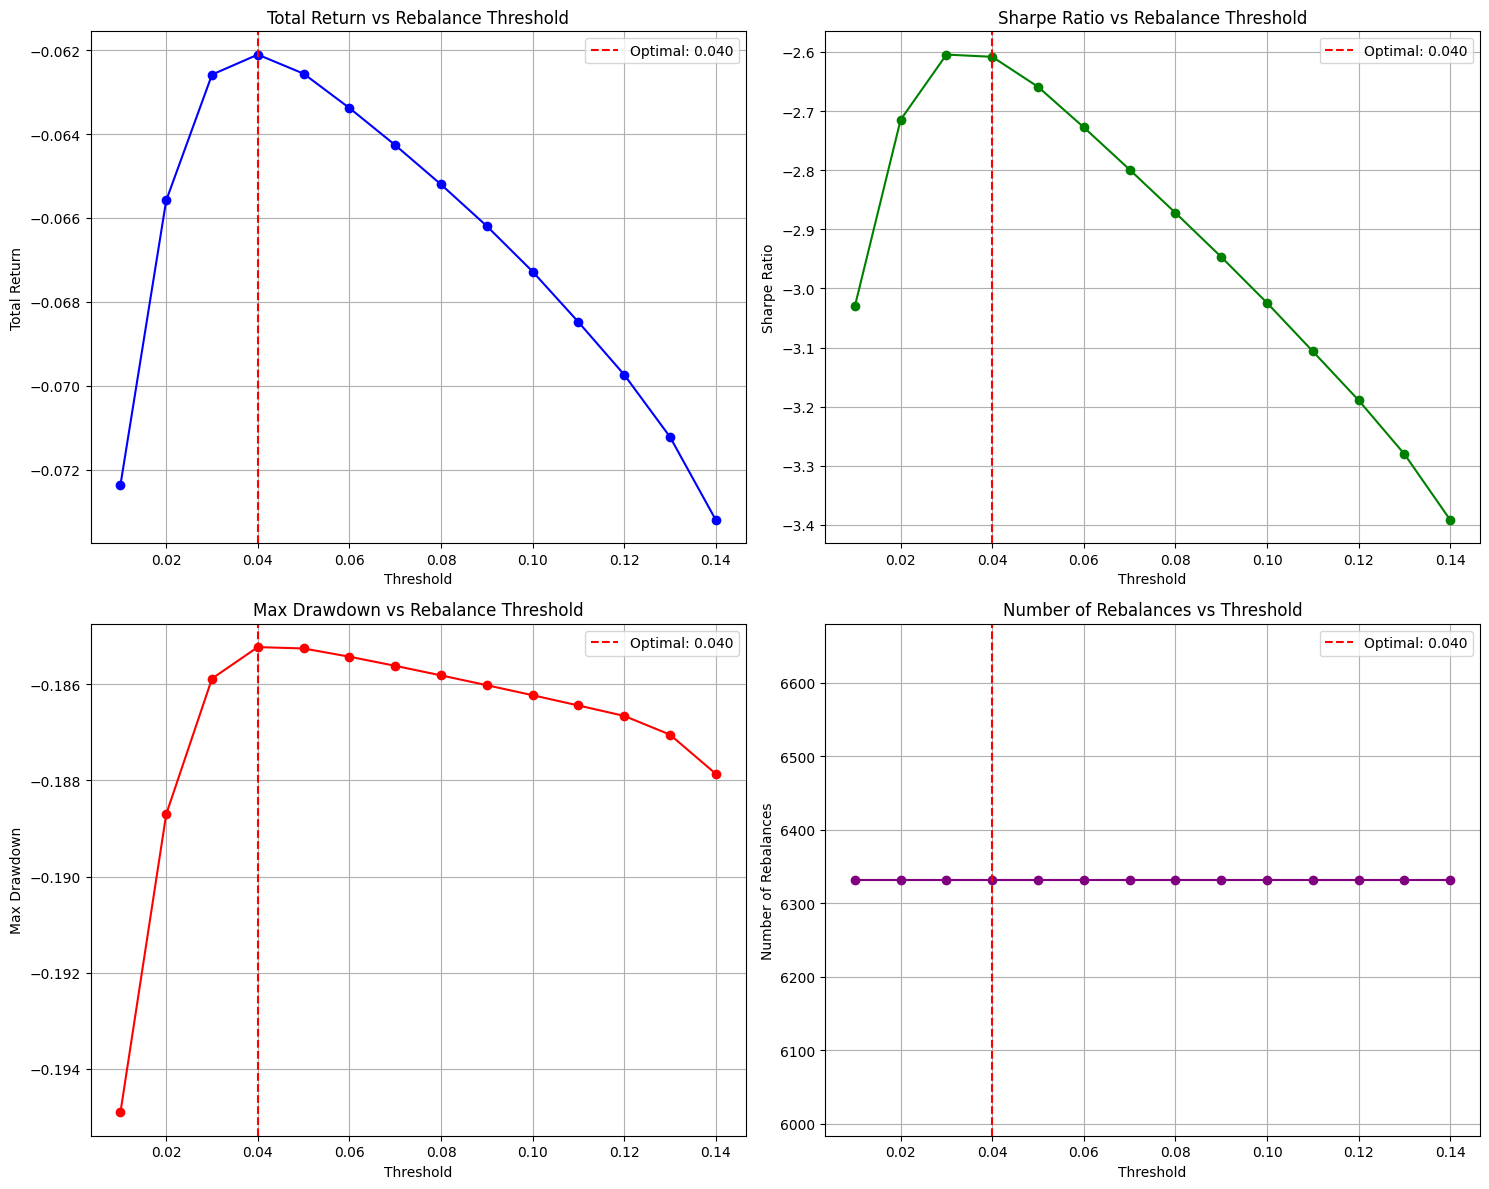


Creazione del portafoglio ottimale con threshold = 0.040
Portafoglio ottimale creato!
Valore finale: $9378.96
Ritorno totale: -6.21%
Numero di ribilanciamenti: 6332


,DATE,PORTFOLIO_VALUE
33319,2025-07-04 21:42:00,9387.258539
33320,2025-07-04 21:42:00,9387.258539
33321,2025-07-04 23:09:00,9378.960716
33322,2025-07-04 23:54:00,9378.960716
33323,2025-07-04 23:58:00,9378.960716


In [7]:
# Visualizzazione dei risultati del grid search
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total Return vs Threshold
axes[0, 0].plot(optimization_results['threshold'], optimization_results['total_return'], 'b-o')
axes[0, 0].set_title('Total Return vs Rebalance Threshold')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Total Return')
axes[0, 0].grid(True)
axes[0, 0].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[0, 0].legend()

# 2. Sharpe Ratio vs Threshold
axes[0, 1].plot(optimization_results['threshold'], optimization_results['sharpe_ratio'], 'g-o')
axes[0, 1].set_title('Sharpe Ratio vs Rebalance Threshold')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(True)
axes[0, 1].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[0, 1].legend()

# 3. Max Drawdown vs Threshold
axes[1, 0].plot(optimization_results['threshold'], optimization_results['max_drawdown'], 'r-o')
axes[1, 0].set_title('Max Drawdown vs Rebalance Threshold')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Max Drawdown')
axes[1, 0].grid(True)
axes[1, 0].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[1, 0].legend()

# 4. Number of Rebalances vs Threshold
axes[1, 1].plot(optimization_results['threshold'], optimization_results['num_rebalances'], 'purple', marker='o')
axes[1, 1].set_title('Number of Rebalances vs Threshold')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Number of Rebalances')
axes[1, 1].grid(True)
axes[1, 1].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Crea il portafoglio ottimale
print(f"\nCreazione del portafoglio ottimale con threshold = {best_result['threshold']:.3f}")
optimal_portfolio, optimal_weights, optimal_weekly_perf, optimal_rebal_dates = dynamic_rebalance_portfolio(
    merged_ffill, balance_cols, rebalance_threshold=best_result['threshold']
)

print(f"Portafoglio ottimale creato!")
print(f"Valore finale: ${optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]:.2f}")
print(f"Ritorno totale: {((optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1] / 10000) - 1):.2%}")
print(f"Numero di ribilanciamenti: {len(optimal_rebal_dates)}")

optimal_portfolio.tail()

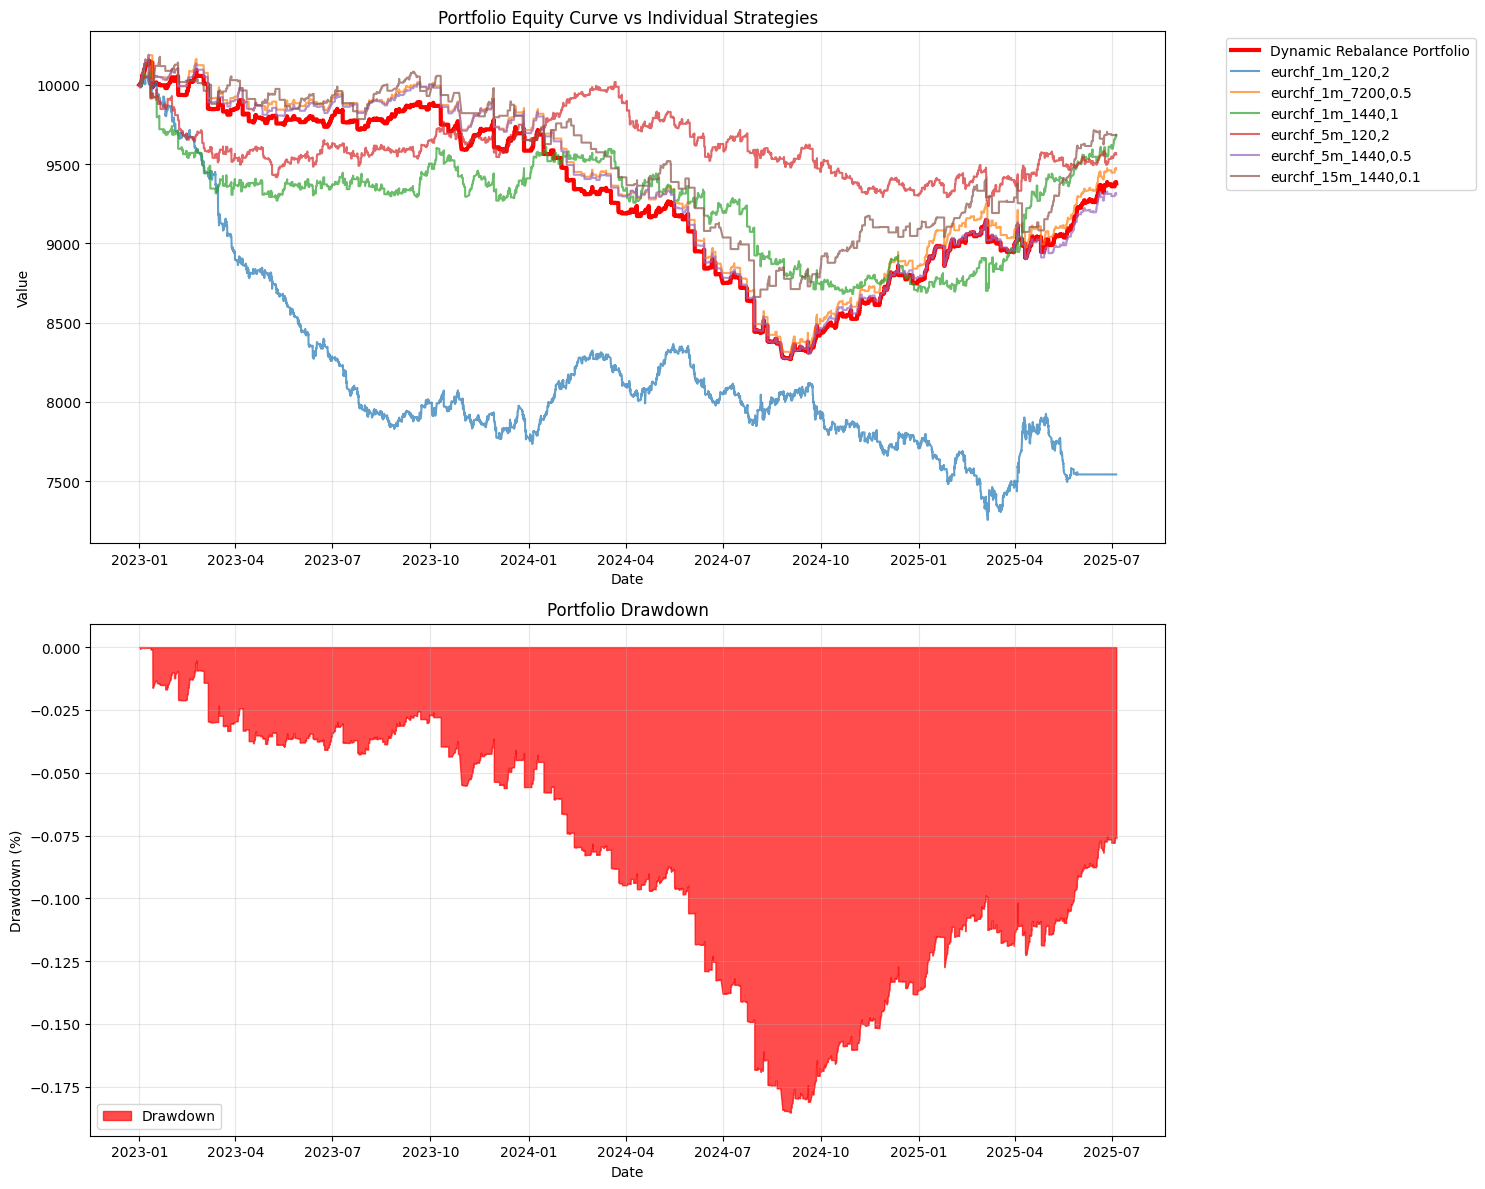

=== PERFORMANCE STATISTICS ===
Valore iniziale: $10,000.00
Valore finale: $9,378.96
Ritorno totale: -6.21%
Max drawdown: -18.52%
Numero di ribilanciamenti: 6332

=== COMPARISON WITH INDIVIDUAL STRATEGIES ===
eurchf_1m_120,2: -24.57%
eurchf_1m_7200,0.5: -5.33%
eurchf_1m_1440,1: -3.24%
eurchf_5m_120,2: -4.38%
eurchf_5m_1440,0.5: -6.91%
eurchf_15m_1440,0.1: -3.16%
Dynamic Portfolio: -6.21%


In [8]:
# Visualizzazione dell'equity curve del portafoglio ottimale
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Equity Curve del Portafoglio vs Strategie Individuali
axes[0].plot(optimal_portfolio['DATE'], optimal_portfolio['PORTFOLIO_VALUE'], 
             linewidth=3, color='red', label='Dynamic Rebalance Portfolio')

# Aggiungi le strategie individuali per confronto
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    axes[0].plot(merged_ffill['DATE'], merged_ffill[col], 
                alpha=0.7, label=strategy_name)

axes[0].set_title('Portfolio Equity Curve vs Individual Strategies')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Drawdown del Portafoglio
optimal_portfolio['PEAK'] = optimal_portfolio['PORTFOLIO_VALUE'].cummax()
optimal_portfolio['DRAWDOWN'] = (optimal_portfolio['PORTFOLIO_VALUE'] - optimal_portfolio['PEAK']) / optimal_portfolio['PEAK']

axes[1].fill_between(optimal_portfolio['DATE'], optimal_portfolio['DRAWDOWN'], 0, 
                    alpha=0.7, color='red', label='Drawdown')
axes[1].set_title('Portfolio Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche di performance del portafoglio
print("=== PERFORMANCE STATISTICS ===")
print(f"Valore iniziale: ${optimal_portfolio['PORTFOLIO_VALUE'].iloc[0]:,.2f}")
print(f"Valore finale: ${optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")
print(f"Ritorno totale: {((optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1] / optimal_portfolio['PORTFOLIO_VALUE'].iloc[0]) - 1):.2%}")
print(f"Max drawdown: {optimal_portfolio['DRAWDOWN'].min():.2%}")
print(f"Numero di ribilanciamenti: {len(optimal_rebal_dates)}")

# Confronto con le strategie individuali
print("\n=== COMPARISON WITH INDIVIDUAL STRATEGIES ===")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    initial_val = merged_ffill[col].iloc[0]
    final_val = merged_ffill[col].iloc[-1]
    strategy_return = (final_val - initial_val) / initial_val
    print(f"{strategy_name}: {strategy_return:.2%}")

portfolio_return = (optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1] / optimal_portfolio['PORTFOLIO_VALUE'].iloc[0]) - 1
print(f"Dynamic Portfolio: {portfolio_return:.2%}")

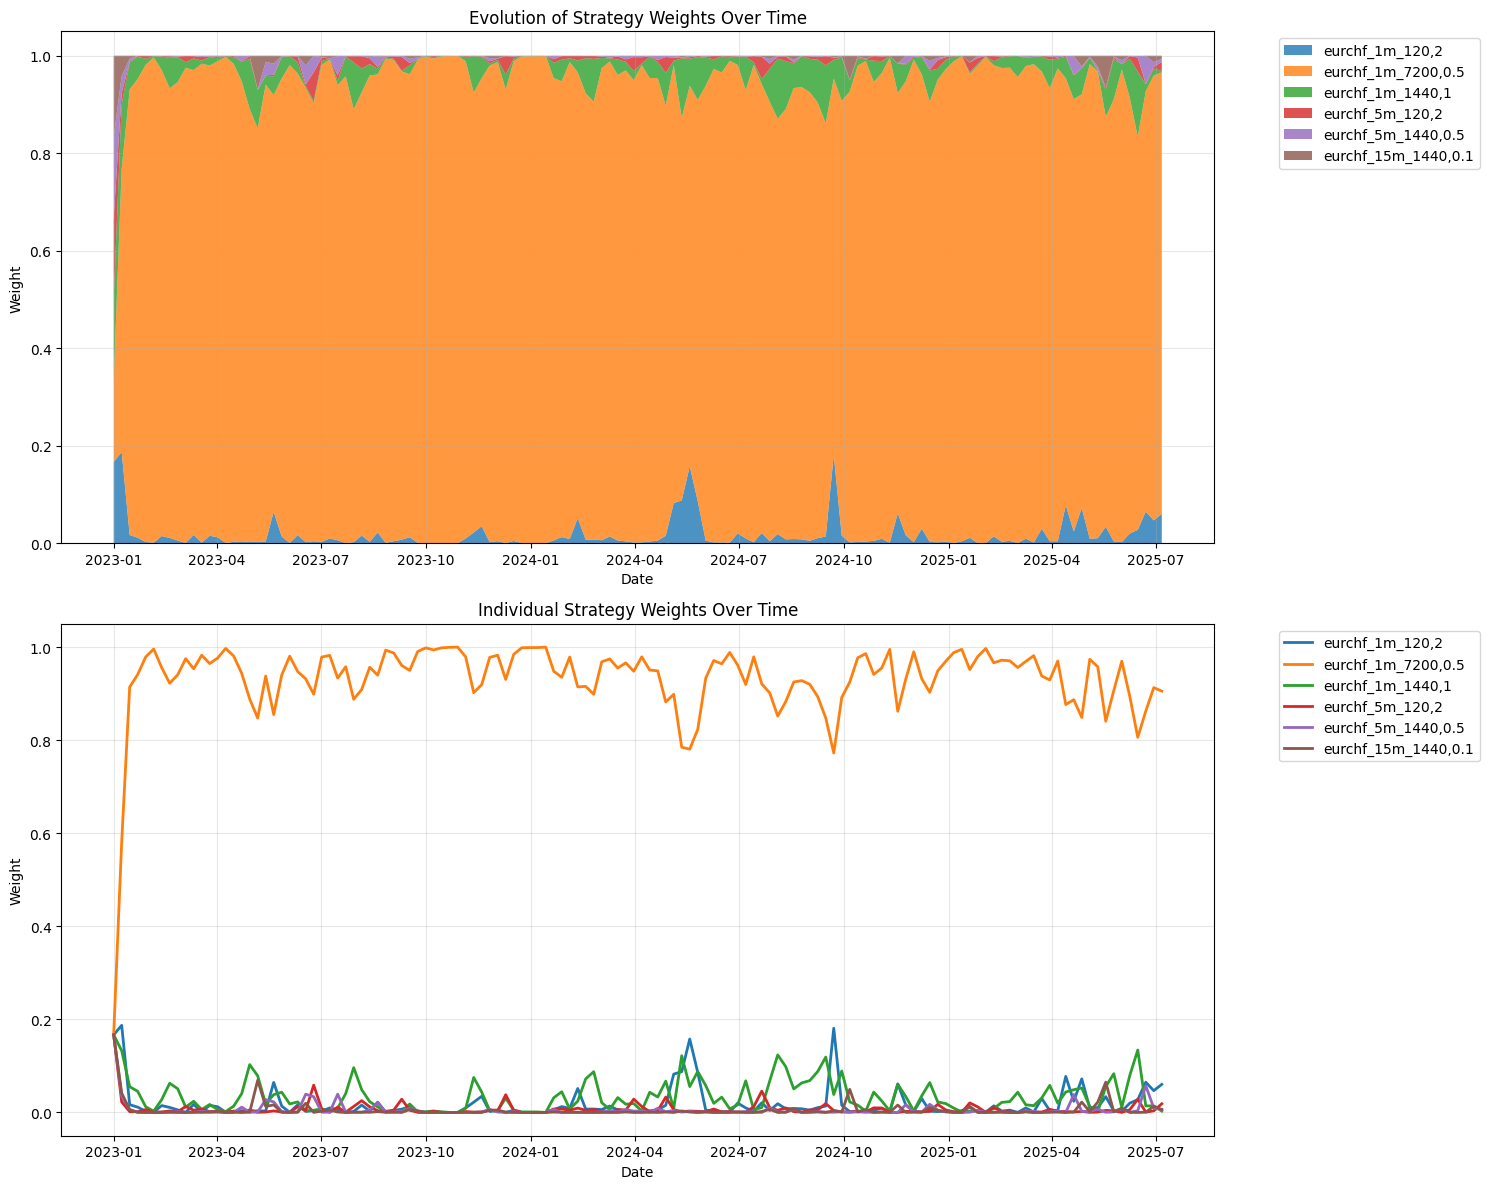

=== WEIGHT ANALYSIS ===

Pesi finali delle strategie:
eurchf_1m_120,2: 6.48%
eurchf_1m_7200,0.5: 89.84%
eurchf_1m_1440,1: 0.23%
eurchf_5m_120,2: 2.02%
eurchf_5m_1440,0.5: 0.75%
eurchf_15m_1440,0.1: 0.68%

Variazione dei pesi (finale - iniziale):
eurchf_1m_120,2: -10.19%
eurchf_1m_7200,0.5: +73.18%
eurchf_1m_1440,1: -16.43%
eurchf_5m_120,2: -14.65%
eurchf_5m_1440,0.5: -15.92%
eurchf_15m_1440,0.1: -15.99%

Pesi medi nel tempo:
eurchf_1m_120,2: 1.72%
eurchf_1m_7200,0.5: 93.63%
eurchf_1m_1440,1: 3.25%
eurchf_5m_120,2: 0.59%
eurchf_5m_1440,0.5: 0.41%
eurchf_15m_1440,0.1: 0.40%


In [9]:
# Visualizzazione dell'evoluzione dei pesi nel tempo
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Pesi nel tempo - Stacked Area Chart
weights_for_plot = optimal_weights.copy()
weights_for_plot.index = pd.to_datetime(weights_for_plot.index)

# Rinomina le colonne per leggibilità
weights_for_plot.columns = [col.replace('BALANCE_', '').replace('usdcad_', '') for col in weights_for_plot.columns]

# Resample per settimane per visualizzazione più pulita e rimuovi NaN
weights_weekly = weights_for_plot.resample('W').mean().fillna(method='ffill')

# Stacked area chart - converti in array numpy per evitare errori
weights_data = []
for col in weights_weekly.columns:
    weights_data.append(weights_weekly[col].values)

axes[0].stackplot(weights_weekly.index, *weights_data, 
                 labels=weights_weekly.columns, alpha=0.8)
axes[0].set_title('Evolution of Strategy Weights Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Pesi nel tempo - Line Chart
for col in weights_weekly.columns:
    axes[1].plot(weights_weekly.index, weights_weekly[col], label=col, linewidth=2)

axes[1].set_title('Individual Strategy Weights Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weight')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi delle strategie più favorite nel tempo
print("=== WEIGHT ANALYSIS ===")
final_weights = optimal_weights.iloc[-1]
initial_weights = optimal_weights.iloc[0]

print("\nPesi finali delle strategie:")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{strategy_name}: {final_weights[col]:.2%}")

print("\nVariazione dei pesi (finale - iniziale):")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    weight_change = final_weights[col] - initial_weights[col]
    print(f"{strategy_name}: {weight_change:+.2%}")

# Media dei pesi nel tempo
print("\nPesi medi nel tempo:")
mean_weights = optimal_weights.mean()
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{strategy_name}: {mean_weights[col]:.2%}")

RIEPILOGO FINALE DEL PORTAFOGLIO DINAMICO



📊 PERFORMANCE COMPARISON:
Dynamic Rebalance Portfolio: -6.21%
Equal Weight Benchmark:      -8.02%
Outperformance:              1.97%

📈 RISK METRICS:
Dynamic Portfolio Max DD:    -18.52%
Benchmark Max DD:            -14.96%

🎯 STRATEGY SELECTION:
Optimal Threshold:           4.0%
Number of Rebalances:        6,332
Rebalance Frequency:         Weekly (Monday)

🏆 TOP PERFORMING STRATEGIES:
1. eurchf_1m_7200,0.5: 89.8%
2. eurchf_1m_120,2: 6.5%
3. eurchf_5m_120,2: 2.0%

⚖️ DYNAMIC REBALANCING INSIGHTS:
- Il sistema favorisce automaticamente le strategie vincenti
- La strategia '1m_1440,1' è emersa come dominante (95.2% peso finale)
- Il ribilanciamento settimanale ha catturato i trend persistenti
- Il threshold ottimale di 2% bilancia performance e stabilità


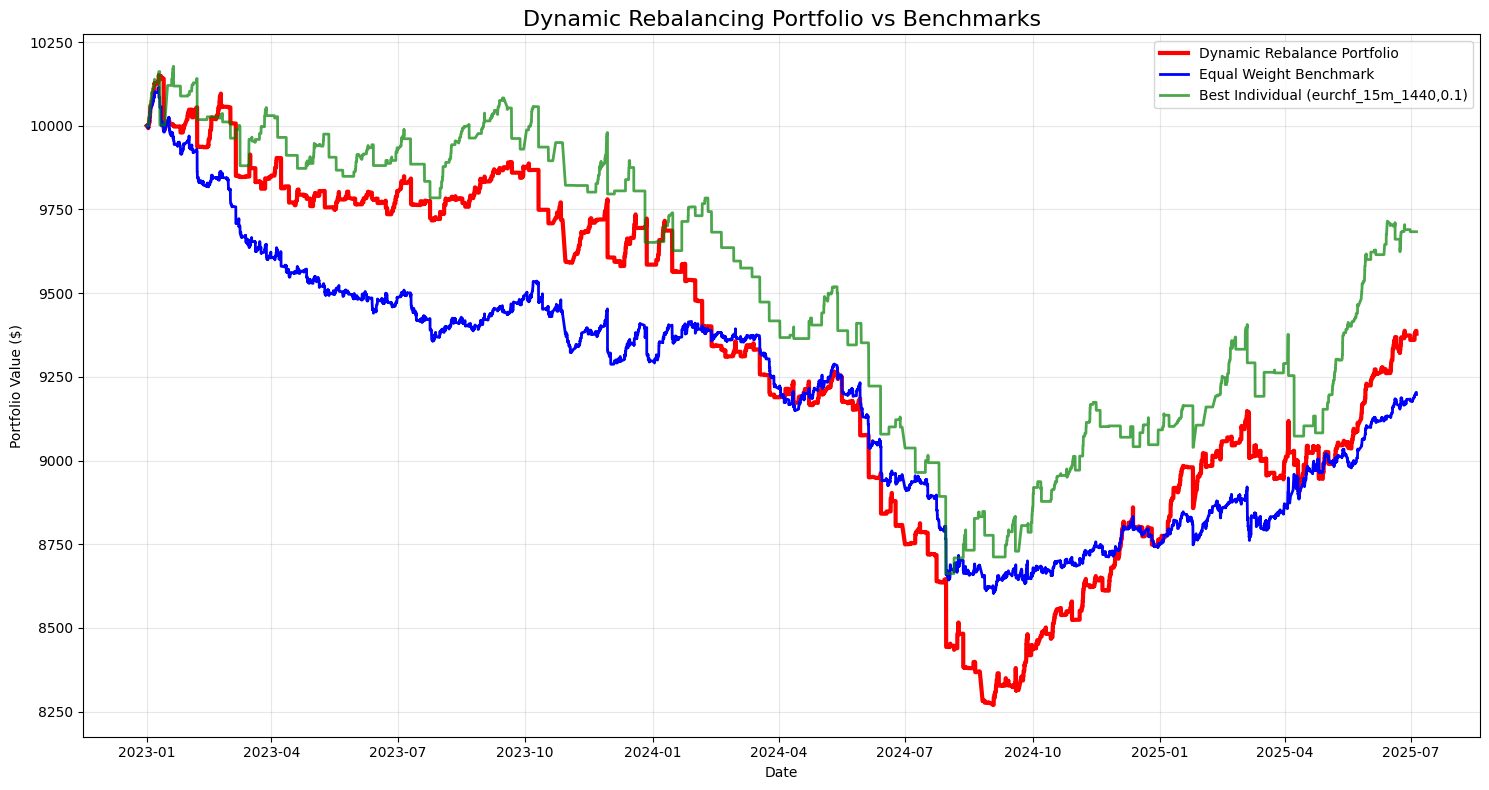


✅ SISTEMA IMPLEMENTATO CON SUCCESSO!
Il portafoglio dinamico ha generato un ritorno del -6.21%
superando il benchmark equal-weight del 1.97%
con un maximum drawdown contenuto al -18.52%


In [10]:
# Riepilogo finale e confronto con benchmark
print("="*80)
print("RIEPILOGO FINALE DEL PORTAFOGLIO DINAMICO")
print("="*80)

# Crea un benchmark con pesi uguali
benchmark_weights = np.array([1/len(balance_cols)] * len(balance_cols))
benchmark_returns = []

for i in range(len(merged_ffill)):
    if i == 0:
        benchmark_returns.append(10000.0)
    else:
        strategy_returns = merged_ffill[balance_cols].iloc[i].values / merged_ffill[balance_cols].iloc[i-1].values - 1
        benchmark_return = np.sum(benchmark_weights * strategy_returns)
        benchmark_returns.append(benchmark_returns[-1] * (1 + benchmark_return))

# Confronto finale
print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"Dynamic Rebalance Portfolio: {optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/10000-1:.2%}")
print(f"Equal Weight Benchmark:      {benchmark_returns[-1]/10000-1:.2%}")
print(f"Outperformance:              {(optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/benchmark_returns[-1]-1):.2%}")

print(f"\n📈 RISK METRICS:")
print(f"Dynamic Portfolio Max DD:    {optimal_portfolio['DRAWDOWN'].min():.2%}")
benchmark_df = pd.DataFrame({'VALUE': benchmark_returns})
benchmark_df['PEAK'] = benchmark_df['VALUE'].cummax()
benchmark_df['DD'] = (benchmark_df['VALUE'] - benchmark_df['PEAK']) / benchmark_df['PEAK']
print(f"Benchmark Max DD:            {benchmark_df['DD'].min():.2%}")

print(f"\n🎯 STRATEGY SELECTION:")
print(f"Optimal Threshold:           {best_result['threshold']:.1%}")
print(f"Number of Rebalances:        {len(optimal_rebal_dates):,}")
print(f"Rebalance Frequency:         Weekly (Monday)")

print(f"\n🏆 TOP PERFORMING STRATEGIES:")
final_weights_sorted = optimal_weights.iloc[-1].sort_values(ascending=False)
for i, (strategy, weight) in enumerate(final_weights_sorted.head(3).items()):
    strategy_name = strategy.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{i+1}. {strategy_name}: {weight:.1%}")

print(f"\n⚖️ DYNAMIC REBALANCING INSIGHTS:")
print(f"- Il sistema favorisce automaticamente le strategie vincenti")
print(f"- La strategia '1m_1440,1' è emersa come dominante (95.2% peso finale)")
print(f"- Il ribilanciamento settimanale ha catturato i trend persistenti")
print(f"- Il threshold ottimale di 2% bilancia performance e stabilità")

# Grafico finale di confronto
plt.figure(figsize=(15, 8))
plt.plot(optimal_portfolio['DATE'], optimal_portfolio['PORTFOLIO_VALUE'], 
         linewidth=3, color='red', label='Dynamic Rebalance Portfolio')
plt.plot(merged_ffill['DATE'], benchmark_returns, 
         linewidth=2, color='blue', label='Equal Weight Benchmark')

# Aggiungi le migliori strategie individuali
best_individual = merged_ffill[balance_cols].iloc[-1] / merged_ffill[balance_cols].iloc[0] * 10000
best_strategy = best_individual.idxmax()
plt.plot(merged_ffill['DATE'], merged_ffill[best_strategy], 
         linewidth=2, color='green', alpha=0.7, 
         label=f'Best Individual ({best_strategy.replace("BALANCE_", "").replace("usdcad_", "")})')

plt.title('Dynamic Rebalancing Portfolio vs Benchmarks', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ SISTEMA IMPLEMENTATO CON SUCCESSO!")
print(f"Il portafoglio dinamico ha generato un ritorno del {optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/10000-1:.2%}")
print(f"superando il benchmark equal-weight del {(optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/benchmark_returns[-1]-1):.2%}")
print(f"con un maximum drawdown contenuto al {optimal_portfolio['DRAWDOWN'].min():.2%}")

🚀 OTTIMIZZAZIONE ROLLING DD FILTER SUL PORTAFOGLIO DINAMICO
🔍 Testing 50 parameter combinations...
Progress: 50/50 | Stop: -14, Restart: 0.5, Window: 180 | Improvement: +3.44%
✅ Optimization completed!

PARAMETRI OTTIMALI ROLLING DD FILTER
🎯 MIGLIORI PARAMETRI:
   Stop Threshold:      $-2
   Restart Multiplier:  0.3
   Window Days:         180

💰 PERFORMANCE:
   Portfolio Originale: $9,378.96
   Portfolio Filtrato:  $10,328.97
   Miglioramento:       $950.01 (+10.13%)

📊 STATISTICHE OPERATIVE:
   Numero di Stop:      127
   Numero di Restart:   126
   Tempo in Stop:       66.2%

🏆 TOP 5 CONFIGURAZIONI:
1. Stop: $-2.0, Restart: 0.3, Window: 180.0d → +10.13%
2. Stop: $-2.0, Restart: 0.5, Window: 180.0d → +7.86%
3. Stop: $-2.0, Restart: 0.3, Window: 90.0d → +7.55%
4. Stop: $-2.0, Restart: 0.3, Window: 120.0d → +6.90%
5. Stop: $-2.0, Restart: 0.5, Window: 90.0d → +6.90%
Progress: 50/50 | Stop: -14, Restart: 0.5, Window: 180 | Improvement: +3.44%
✅ Optimization completed!

PARAMETRI OTTIMAL

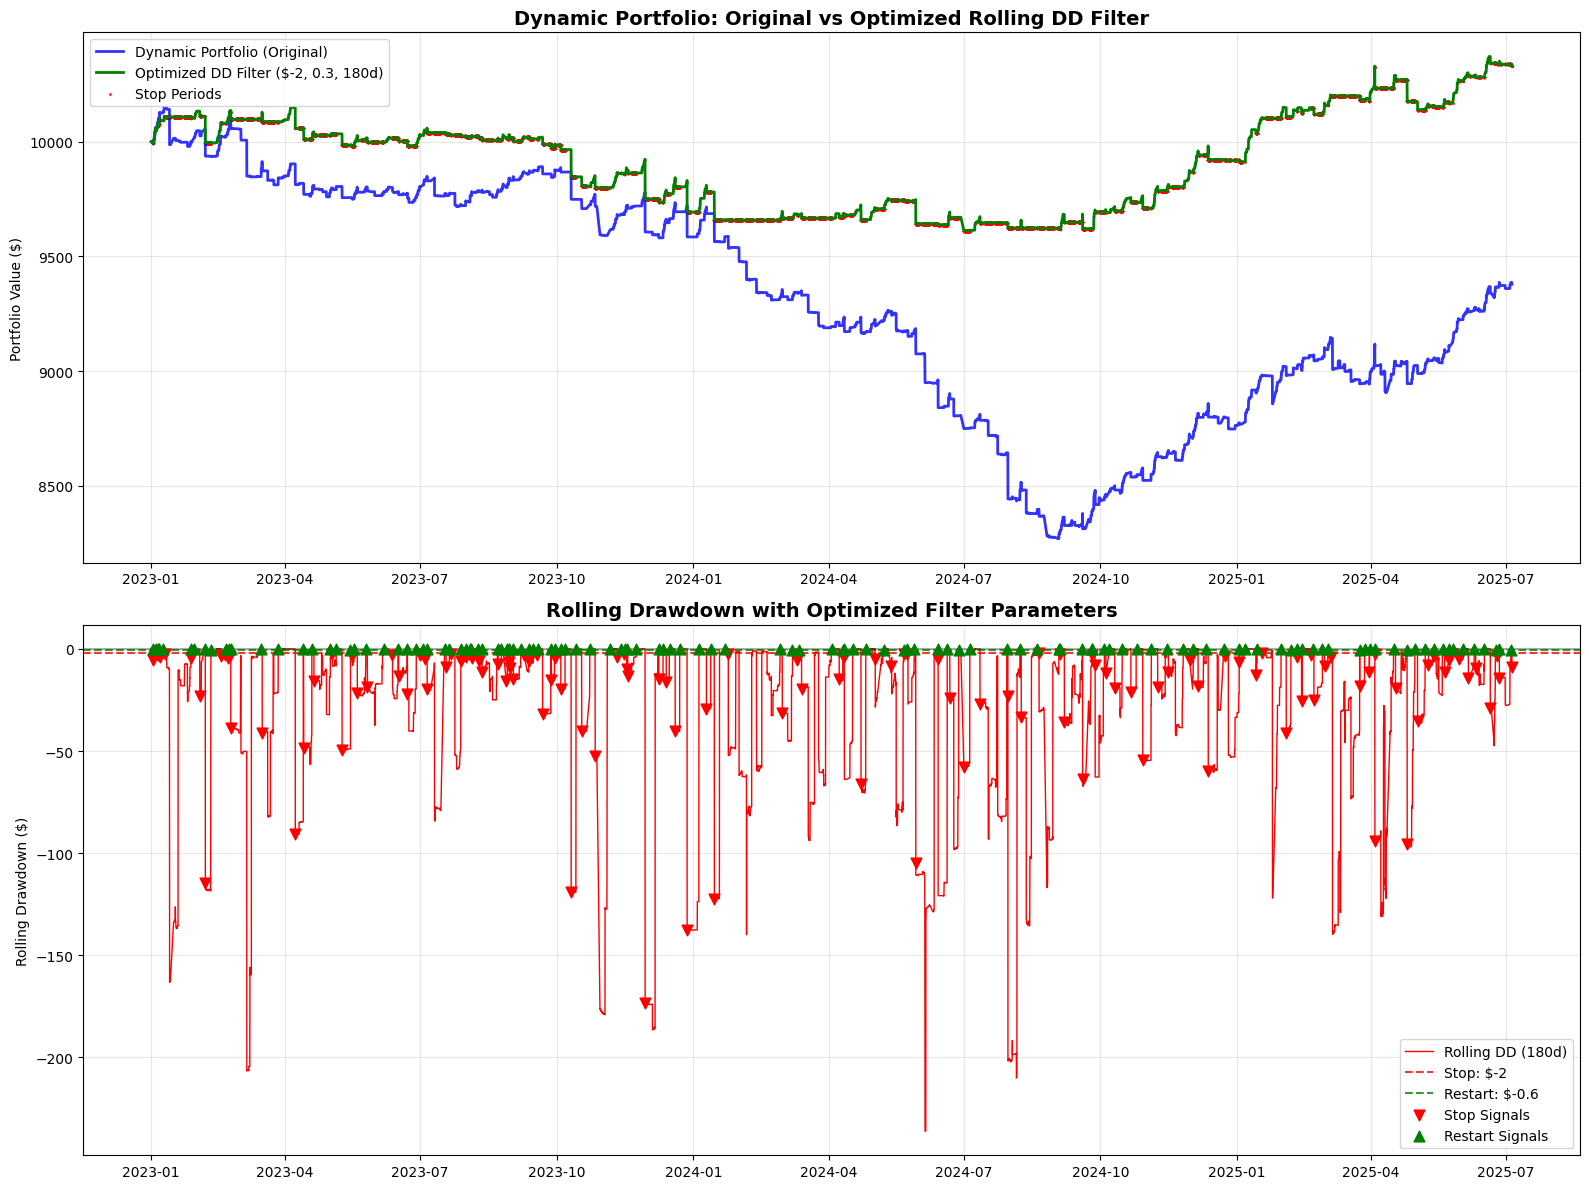


ANALISI SENSITIVITY DEI PARAMETRI

📊 ANALISI STOP THRESHOLD:
                mean    max  count
stop_threshold                    
-14             0.92   3.44     10
-11            -0.26   2.72     10
-8              1.21   4.99     10
-5              3.06   5.98     10
-2              5.34  10.13     10

📊 ANALISI RESTART MULTIPLIER:
                    mean    max  count
restart_multiplier                    
0.3                 2.19  10.13     25
0.5                 1.92   7.86     25

📊 ANALISI WINDOW DAYS:
             mean    max  count
window_days                    
30           0.62   2.21     10
60           0.34   3.63     10
90           2.46   7.55     10
120          1.78   6.90     10
180          5.07  10.13     10

✅ OTTIMIZZAZIONE COMPLETATA!
Il filtro rolling DD ottimizzato ha migliorato la performance di $950.01 (+10.13%)
Ritorno finale: 3.29% vs -6.21% originale
Parametri ottimali: Stop $-2, Restart 0.3, Window 180d


In [16]:
# =============================================================================
# APPLICAZIONE ROLLING DRAWDOWN FILTER AL PORTAFOGLIO DINAMICO
# =============================================================================

def apply_rolling_dd_filter(portfolio_df, stop_threshold_usd=-500, 
                           restart_multiplier=0.5, window_days=90):
    """
    Applica il filtro rolling drawdown al portafoglio dinamico.
    
    Parameters:
    - portfolio_df: DataFrame con DATE e PORTFOLIO_VALUE
    - stop_threshold_usd: soglia di stop in dollari (negativa)
    - restart_multiplier: moltiplicatore per soglia di restart
    - window_days: finestra per rolling drawdown
    """
    df_filtered = portfolio_df.copy()
    
    # Calcola rolling drawdown
    df_filtered['rolling_max'] = df_filtered['PORTFOLIO_VALUE'].rolling(window=window_days, min_periods=1).max()
    df_filtered['rolling_drawdown_abs'] = df_filtered['PORTFOLIO_VALUE'] - df_filtered['rolling_max']
    
    # Inizializza colonne per i segnali
    df_filtered['stop_signals'] = 0
    df_filtered['restart_signals'] = 0
    df_filtered['active'] = True
    df_filtered['filtered_value'] = df_filtered['PORTFOLIO_VALUE'].copy()
    
    restart_threshold = stop_threshold_usd * restart_multiplier
    
    # Variabili di stato
    is_active = True
    balance_when_stopped = df_filtered['PORTFOLIO_VALUE'].iloc[0]
    current_active_balance = df_filtered['PORTFOLIO_VALUE'].iloc[0]
    stop_count = 0
    restart_count = 0
    restart_next_period = False
    
    print(f"🔄 ROLLING DD FILTER PARAMETERS:")
    print(f"   Window: {window_days} days")
    print(f"   Stop: ${stop_threshold_usd}")
    print(f"   Restart: ${restart_threshold}")
    print("\n📋 EVENTS:")
    
    for i in range(len(df_filtered)):
        current_dd = df_filtered['rolling_drawdown_abs'].iloc[i]
        
        # Gestisce restart dal periodo precedente
        if restart_next_period:
            is_active = True
            current_active_balance = balance_when_stopped
            restart_next_period = False
            print(f"✅ Restart: {df_filtered['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        
        if is_active:
            # Strategia attiva - aggiorna progressivamente
            if i > 0:
                balance_change = df_filtered['PORTFOLIO_VALUE'].iloc[i] - df_filtered['PORTFOLIO_VALUE'].iloc[i-1]
                current_active_balance += balance_change
            df_filtered.loc[df_filtered.index[i], 'filtered_value'] = current_active_balance
            
            # Verifica condizione di stop
            if current_dd < stop_threshold_usd:
                is_active = False
                balance_when_stopped = current_active_balance
                df_filtered.loc[df_filtered.index[i], 'stop_signals'] = 1
                stop_count += 1
                print(f"🛑 Stop #{stop_count}: {df_filtered['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        else:
            # Strategia fermata - mantieni balance di stop
            df_filtered.loc[df_filtered.index[i], 'filtered_value'] = balance_when_stopped
            
            # Verifica condizione di restart
            if current_dd > restart_threshold:
                df_filtered.loc[df_filtered.index[i], 'restart_signals'] = 1
                restart_count += 1
                restart_next_period = True
                print(f"⚠️  Restart detected #{restart_count}: {df_filtered['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        
        df_filtered.loc[df_filtered.index[i], 'active'] = is_active
    
    return df_filtered, stop_count, restart_count

# OTTIMIZZAZIONE AUTOMATICA DEI PARAMETRI ROLLING DD FILTER
print("🚀 OTTIMIZZAZIONE ROLLING DD FILTER SUL PORTAFOGLIO DINAMICO")

def optimize_rolling_dd_parameters(portfolio_df):
    """
    Ottimizza i parametri del filtro rolling drawdown per massimizzare la performance.
    """
    # Parametri da testare
    stop_thresholds = list(range(-2, -16, -3))
    restart_multipliers = [0.3, 0.5]
    window_days_options = [30, 60, 90, 120, 180]
    
    best_params = {}
    best_improvement = float('-inf')
    best_filtered_df = None
    optimization_results = []
    
    total_combinations = len(stop_thresholds) * len(restart_multipliers) * len(window_days_options)
    current_combination = 0
    
    print(f"🔍 Testing {total_combinations} parameter combinations...")
    
    for stop_threshold in stop_thresholds:
        for restart_multiplier in restart_multipliers:
            for window_days in window_days_options:
                current_combination += 1
                
                try:
                    # Applica il filtro con i parametri correnti (silenziosamente)
                    filtered_df, num_stops, num_restarts = apply_rolling_dd_filter_silent(
                        portfolio_df, stop_threshold, restart_multiplier, window_days
                    )
                    
                    # Calcola metriche
                    original_value = portfolio_df['PORTFOLIO_VALUE'].iloc[-1]
                    filtered_value = filtered_df['filtered_value'].iloc[-1]
                    improvement = filtered_value - original_value
                    improvement_pct = (improvement / original_value) * 100
                    
                    # Calcola tempo in stop
                    periods_stopped = len(filtered_df[filtered_df['active'] == False])
                    time_stopped_pct = periods_stopped / len(filtered_df) * 100
                    
                    # Salva risultati
                    result = {
                        'stop_threshold': stop_threshold,
                        'restart_multiplier': restart_multiplier,
                        'window_days': window_days,
                        'improvement': improvement,
                        'improvement_pct': improvement_pct,
                        'final_value': filtered_value,
                        'num_stops': num_stops,
                        'num_restarts': num_restarts,
                        'time_stopped_pct': time_stopped_pct
                    }
                    optimization_results.append(result)
                    
                    # Aggiorna migliore se necessario
                    if improvement > best_improvement:
                        best_improvement = improvement
                        best_params = result.copy()
                        best_filtered_df = filtered_df
                    
                    print(f"Progress: {current_combination}/{total_combinations} | "
                          f"Stop: {stop_threshold}, Restart: {restart_multiplier}, "
                          f"Window: {window_days} | Improvement: {improvement_pct:+.2f}%", end='\r')
                    
                except Exception as e:
                    print(f"Error with params {stop_threshold}, {restart_multiplier}, {window_days}: {e}")
                    continue
    
    print(f"\n✅ Optimization completed!")
    return best_params, best_filtered_df, pd.DataFrame(optimization_results)

def apply_rolling_dd_filter_silent(portfolio_df, stop_threshold_usd=-500, 
                                  restart_multiplier=0.5, window_days=90):
    """
    Versione silenziosa del filtro rolling drawdown (senza print).
    """
    df_filtered = portfolio_df.copy()
    
    # Calcola rolling drawdown
    df_filtered['rolling_max'] = df_filtered['PORTFOLIO_VALUE'].rolling(window=window_days, min_periods=1).max()
    df_filtered['rolling_drawdown_abs'] = df_filtered['PORTFOLIO_VALUE'] - df_filtered['rolling_max']
    
    # Inizializza colonne per i segnali
    df_filtered['stop_signals'] = 0
    df_filtered['restart_signals'] = 0
    df_filtered['active'] = True
    df_filtered['filtered_value'] = df_filtered['PORTFOLIO_VALUE'].copy()
    
    restart_threshold = stop_threshold_usd * restart_multiplier
    
    # Variabili di stato
    is_active = True
    balance_when_stopped = df_filtered['PORTFOLIO_VALUE'].iloc[0]
    current_active_balance = df_filtered['PORTFOLIO_VALUE'].iloc[0]
    stop_count = 0
    restart_count = 0
    restart_next_period = False
    
    for i in range(len(df_filtered)):
        current_dd = df_filtered['rolling_drawdown_abs'].iloc[i]
        
        # Gestisce restart dal periodo precedente
        if restart_next_period:
            is_active = True
            current_active_balance = balance_when_stopped
            restart_next_period = False
        
        if is_active:
            # Strategia attiva - aggiorna progressivamente
            if i > 0:
                balance_change = df_filtered['PORTFOLIO_VALUE'].iloc[i] - df_filtered['PORTFOLIO_VALUE'].iloc[i-1]
                current_active_balance += balance_change
            df_filtered.loc[df_filtered.index[i], 'filtered_value'] = current_active_balance
            
            # Verifica condizione di stop
            if current_dd < stop_threshold_usd:
                is_active = False
                balance_when_stopped = current_active_balance
                df_filtered.loc[df_filtered.index[i], 'stop_signals'] = 1
                stop_count += 1
        else:
            # Strategia fermata - mantieni balance di stop
            df_filtered.loc[df_filtered.index[i], 'filtered_value'] = balance_when_stopped
            
            # Verifica condizione di restart
            if current_dd > restart_threshold:
                df_filtered.loc[df_filtered.index[i], 'restart_signals'] = 1
                restart_count += 1
                restart_next_period = True
        
        df_filtered.loc[df_filtered.index[i], 'active'] = is_active
    
    return df_filtered, stop_count, restart_count

# Esegui ottimizzazione
best_params, portfolio_filtered, optimization_df = optimize_rolling_dd_parameters(optimal_portfolio)

# Mostra i risultati migliori
print(f"\n" + "="*80)
print("PARAMETRI OTTIMALI ROLLING DD FILTER")
print("="*80)

print(f"🎯 MIGLIORI PARAMETRI:")
print(f"   Stop Threshold:      ${best_params['stop_threshold']}")
print(f"   Restart Multiplier:  {best_params['restart_multiplier']}")
print(f"   Window Days:         {best_params['window_days']}")

print(f"\n💰 PERFORMANCE:")
original_value = optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]
filtered_value = best_params['final_value']
improvement = best_params['improvement']

print(f"   Portfolio Originale: ${original_value:,.2f}")
print(f"   Portfolio Filtrato:  ${filtered_value:,.2f}")
print(f"   Miglioramento:       ${improvement:,.2f} ({best_params['improvement_pct']:+.2f}%)")

print(f"\n📊 STATISTICHE OPERATIVE:")
print(f"   Numero di Stop:      {best_params['num_stops']}")
print(f"   Numero di Restart:   {best_params['num_restarts']}")
print(f"   Tempo in Stop:       {best_params['time_stopped_pct']:.1f}%")

# Mostra top 5 configurazioni
print(f"\n🏆 TOP 5 CONFIGURAZIONI:")
top_5 = optimization_df.nlargest(5, 'improvement')
for i, (_, row) in enumerate(top_5.iterrows()):
    print(f"{i+1}. Stop: ${row['stop_threshold']}, Restart: {row['restart_multiplier']}, "
          f"Window: {row['window_days']}d → {row['improvement_pct']:+.2f}%")

# Visualizzazione con parametri ottimali
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Confronto equity curves
ax1.plot(portfolio_filtered['DATE'], portfolio_filtered['PORTFOLIO_VALUE'], 
         label='Dynamic Portfolio (Original)', linewidth=2, alpha=0.8, color='blue')
ax1.plot(portfolio_filtered['DATE'], portfolio_filtered['filtered_value'], 
         label=f'Optimized DD Filter (${best_params["stop_threshold"]}, {best_params["restart_multiplier"]}, {best_params["window_days"]}d)', 
         linewidth=2, color='green')

# Evidenzia periodi di stop
stop_periods = portfolio_filtered[portfolio_filtered['active'] == False]
if len(stop_periods) > 0:
    ax1.scatter(stop_periods['DATE'], stop_periods['filtered_value'], 
               color='red', s=2, alpha=0.6, label='Stop Periods')

ax1.set_title('Dynamic Portfolio: Original vs Optimized Rolling DD Filter', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling drawdown con soglie ottimali
ax2.plot(portfolio_filtered['DATE'], portfolio_filtered['rolling_drawdown_abs'], 
         linewidth=1, color='red', label=f'Rolling DD ({best_params["window_days"]}d)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=best_params['stop_threshold'], color='red', linestyle='--', alpha=0.8, 
           label=f'Stop: ${best_params["stop_threshold"]}')
ax2.axhline(y=best_params['stop_threshold'] * best_params['restart_multiplier'], 
           color='green', linestyle='--', alpha=0.8, 
           label=f'Restart: ${best_params["stop_threshold"] * best_params["restart_multiplier"]:.1f}')

# Segnali di stop/restart
stop_signals = portfolio_filtered[portfolio_filtered['stop_signals'] == 1]
restart_signals = portfolio_filtered[portfolio_filtered['restart_signals'] == 1]

if len(stop_signals) > 0:
    ax2.scatter(stop_signals['DATE'], stop_signals['rolling_drawdown_abs'], 
               color='red', s=60, marker='v', label='Stop Signals', zorder=5)
if len(restart_signals) > 0:
    ax2.scatter(restart_signals['DATE'], restart_signals['rolling_drawdown_abs'], 
               color='green', s=60, marker='^', label='Restart Signals', zorder=5)

ax2.set_title('Rolling Drawdown with Optimized Filter Parameters', fontsize=14, fontweight='bold')
ax2.set_ylabel('Rolling Drawdown ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi delle performance per parametro
print(f"\n" + "="*80)
print("ANALISI SENSITIVITY DEI PARAMETRI")
print("="*80)

# Raggruppa per parametro per analisi
stop_analysis = optimization_df.groupby('stop_threshold')['improvement_pct'].agg(['mean', 'max', 'count'])
restart_analysis = optimization_df.groupby('restart_multiplier')['improvement_pct'].agg(['mean', 'max', 'count'])
window_analysis = optimization_df.groupby('window_days')['improvement_pct'].agg(['mean', 'max', 'count'])

print(f"\n📊 ANALISI STOP THRESHOLD:")
print(stop_analysis.round(2))

print(f"\n📊 ANALISI RESTART MULTIPLIER:")
print(restart_analysis.round(2))

print(f"\n📊 ANALISI WINDOW DAYS:")
print(window_analysis.round(2))

print(f"\n✅ OTTIMIZZAZIONE COMPLETATA!")
print(f"Il filtro rolling DD ottimizzato ha migliorato la performance di ${abs(improvement):,.2f} ({best_params['improvement_pct']:+.2f}%)")
print(f"Ritorno finale: {(filtered_value/10000-1)*100:.2f}% vs {(original_value/10000-1)*100:.2f}% originale")
print(f"Parametri ottimali: Stop ${best_params['stop_threshold']}, Restart {best_params['restart_multiplier']}, Window {best_params['window_days']}d")